In [19]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from functools import reduce
import math

In [81]:
# --- Image Loading ---
def load_model(model_path: str) -> YOLO:
    return YOLO(model_path)

def load_image(image_path: str) -> np.ndarray:
    image_path_obj = Path(image_path)
    img = cv2.imread(str(image_path_obj))
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path_obj}")
    return img

# --- Basic Image Processing ---
def sharpen_image(img: np.ndarray) -> np.ndarray:
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def equalize_histogram(img: np.ndarray) -> np.ndarray:
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb_eq = cv2.merge([y_eq, cr, cb])
    return cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

def to_grayscale(img: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- Skew Detection (PCA) ---
def detect_skew_pca(gray: np.ndarray, debug: bool = False) -> float:
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 10)   
    median_val = np.median(binary)
    lower = int(max(0, 0.66 * median_val))
    upper = int(min(255, 1.33 * median_val))
    edges = cv2.Canny(binary, lower, upper)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0.0
    
    cnt = max(contours, key=cv2.contourArea)
    data_pts = np.array(cnt, dtype=np.float32).reshape(-1, 2)
    mean, eigenvectors = cv2.PCACompute(data_pts, mean=None)
    
    # Tính góc trong không gian radian
    angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])

    if debug:
        draw_debug_pca(gray, mean, eigenvectors, angle)

    # Trả về góc dưới dạng độ
    return np.degrees(angle)


# --- Skew Detection (Hough) ---
def detect_skew_hough(gray: np.ndarray, visualize: bool = False): 
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 10)   
    median_val = np.median(binary)
    lower = int(max(0, 0.66 * median_val))
    upper = int(min(255, 1.33 * median_val))
    edges = cv2.Canny(binary, lower, upper)
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=80, minLineLength=30, maxLineGap=10)

    if lines is None or len(lines) < 1:
        print("Không tìm thấy đủ đường thẳng")
        return None, None, edges

    # Tính độ dài và lưu lại (x1, y1, x2, y2, length)
    lines_with_length = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = np.hypot(x2 - x1, y2 - y1)
        lines_with_length.append((x1, y1, x2, y2, length))

    # Sắp xếp theo độ dài giảm dần
    lines_with_length.sort(key=lambda x: x[4], reverse=True)

    # Lấy 2 đoạn dài nhất
    dominant_lines = lines_with_length[:2]

    angles = []
    for x1, y1, x2, y2, _ in dominant_lines:
        angle_rad = math.atan2(y2 - y1, x2 - x1)
        angle_deg = math.degrees(angle_rad)
        # Đưa về khoảng -90 đến +90
        angle_deg = (angle_deg + 180) % 180
        if angle_deg > 90:
            angle_deg -= 180
        angles.append(angle_deg)
        

    if angles:
        median_angle = np.median(angles)
    else:
        median_angle = 0.0

    if visualize:
        vis_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        for x1, y1, x2, y2, _ in dominant_lines:
            cv2.line(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        plt.imshow(vis_img)
        plt.title(f"Detected Hough Lines angle: {median_angle:.2f} degrees")
        plt.axis("off")
        plt.show()
        print(f"Góc nghiêng Hough: {median_angle:.2f} độ")

    return median_angle, edges

def detect_skew_square(gray: np.ndarray, visualize: bool = False):
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 10)   
    median_val = np.median(binary)
    lower = int(max(0, 0.66 * median_val))
    upper = int(min(255, 1.33 * median_val))
    edges = cv2.Canny(binary, lower, upper)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # TODO: tìm hình vuông lớn nhất trong contours
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            pts = approx.reshape(4, 2)
            # Sắp xếp các điểm
            rect = order_points(pts)
            
            # Tính góc nghiêng từ top-left và top-right
            (tl, tr, br, bl) = rect
            dx = tr[0] - tl[0]
            dy = tr[1] - tl[1]
            angle_rad = math.atan2(dy, dx)
            angle_deg = math.degrees(angle_rad)
            
            print(f"Góc nghiêng: {angle_deg:.2f} độ")
            if visualize:
                vis_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
                cv2.line(vis_img, (int(tl[0]), int(tl[1])), (int(tr[0]), int(tr[1])), (0, 255, 0), 1)
                plt.imshow(vis_img)
                plt.title(f"Detected Square angle: {np.degrees(angle_deg):.2f} degrees")
                plt.axis("off")
                plt.show()

            return angle_deg

    return None

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    rect[0] = pts[np.argmin(s)]       # Top-left
    rect[2] = pts[np.argmax(s)]       # Bottom-right
    rect[1] = pts[np.argmin(diff)]    # Top-right
    rect[3] = pts[np.argmax(diff)]    # Bottom-left

    return rect

def detect_skew_combined(gray: np.ndarray, visualize: bool = False):
    hough_angle, binary = detect_skew_hough(gray, visualize=visualize)
    pca_angle = detect_skew_pca(gray, debug=visualize)
    square_angle = detect_skew_square(gray, visualize=visualize)
    angle = 0.9 * pca_angle + 0.1 * hough_angle
    return (angle, binary) if visualize else angle


# --- Debug Drawing ---
def draw_debug_pca(gray: np.ndarray, mean: np.ndarray, eigenvectors: np.ndarray, angle: float):
    debug_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    center = tuple(np.int32(mean[0]))
    p1 = center + 100 * eigenvectors[0]  # trục chính
    p2 = center + 100 * eigenvectors[1]  # trục phụ

    p1 = tuple(np.int32(p1))
    p2 = tuple(np.int32(p2))

    # Vẽ
    cv2.circle(debug_img, center, 5, (0, 0, 255), -1)
    cv2.line(debug_img, center, p1, (0, 255, 0), 2)  # Principal axis
    cv2.line(debug_img, center, p2, (255, 0, 0), 2)  # Orthogonal axis


    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected PCA angle: {np.degrees(angle):.2f} degrees")
    plt.axis("off")
    plt.show()

# --- Image Rotation ---
def rotate_image_bound(img: np.ndarray, angle: float, mode: str = "inpaint") -> np.ndarray:
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = abs(M[0, 0])
    sin = abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    if mode == "transparent":
        if img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
        return cv2.warpAffine(img, M, (nW, nH), flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))
    elif mode == "interpolate":
        return cv2.warpAffine(img, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    else:
        return cv2.warpAffine(img, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

def rotate_back(img: np.ndarray, angle: float, mode: str = "inpaint") -> np.ndarray:
    return rotate_image_bound(img, -angle, mode)

# --- Pipeline Steps ---
def correct_skew(img: np.ndarray, debug: bool = False, mode: str = "inpaint") -> tuple[np.ndarray, float]:
    gray = img if len(img.shape) == 2 else to_grayscale(img)
    angle, *_ = detect_skew_combined(gray, visualize=debug)
    rotated = rotate_image_bound(img, angle, mode)
    return rotated, angle

def preprocessing_pipeline(img: np.ndarray, debug: bool = False) -> tuple[np.ndarray, float]:
    pipeline = compose(
        equalize_histogram,
        sharpen_image,
        to_grayscale
    )
    processed = pipeline(img)
    corrected, angle = correct_skew(processed, debug=debug)
    return corrected, angle

# --- Inference and Plotting ---
def inference_pipeline(model: YOLO, img: np.ndarray) -> np.ndarray:
    rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB if len(img.shape) == 2 else cv2.COLOR_BGR2RGB)
    results = model(rgb)
    return results

def full_pipeline(model_path: str, image_path: str, debug: bool = False, mode: str = "inpaint"):
    model = load_model(model_path)
    img = load_image(image_path)
    
    preprocessed_img, angle = preprocessing_pipeline(img, debug=debug)
    results = inference_pipeline(model, preprocessed_img)
    
    result_img = results[0].plot()
    result_img_rotated = rotate_back(result_img, angle, mode)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(result_img_rotated)
    plt.axis("off")
    plt.title(f"Detected + Rotated Back (Angle: {angle:.2f}°)")
    plt.show()

def plot_results(results):
    result_img = results[0].plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(result_img)
    plt.axis("off")
    plt.show()

# --- Function Composition ---
def compose(*functions):
    return lambda x: reduce(lambda v, f: f(v), functions, x)

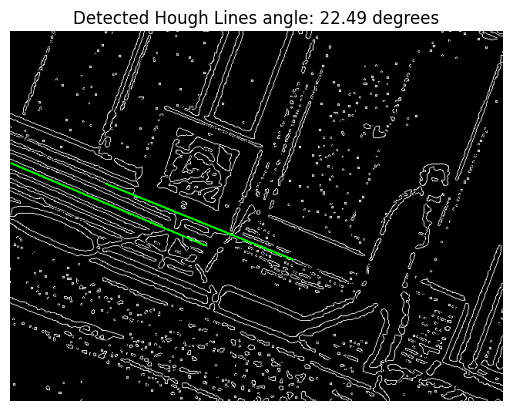

Góc nghiêng Hough: 22.49 độ


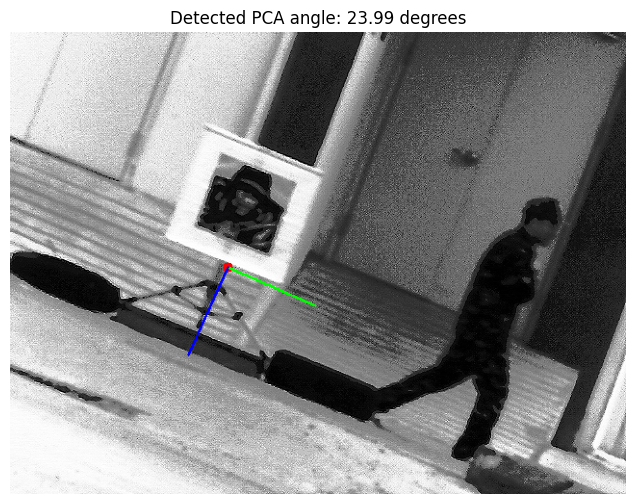

Góc nghiêng: 0.00 độ


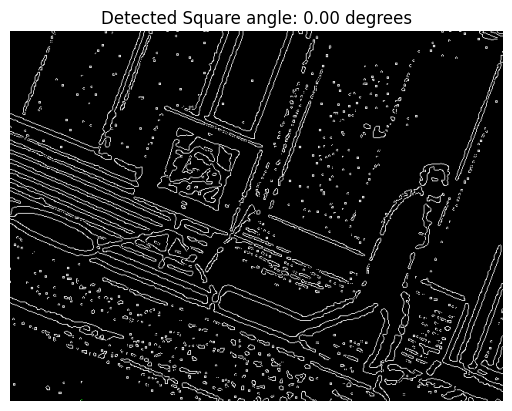


0: 576x640 1 bia, 812.6ms
Speed: 4.4ms preprocess, 812.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


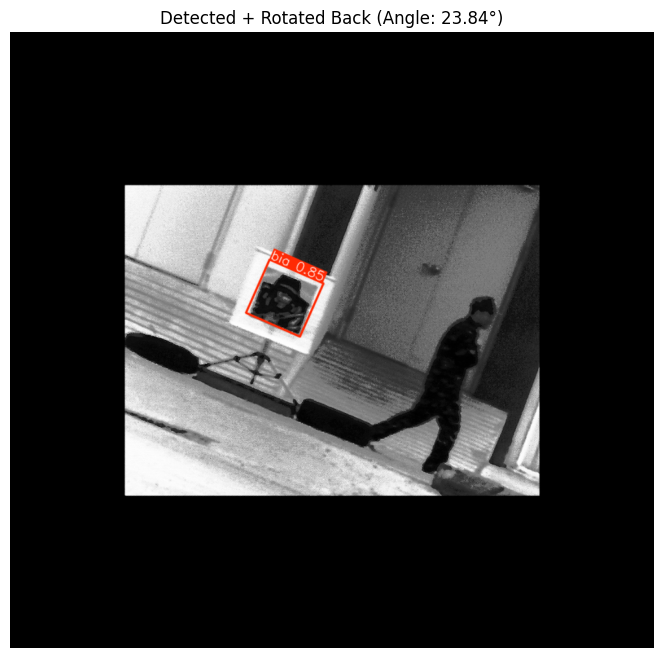

In [82]:
# --- Main ---
if __name__ == "__main__":
    model_path = "yolo-models/yolo11x_bia-4.01.pt"
    image_path = "images/bo du lieu bia so 4/bia4 (3).bmp"

    full_pipeline(model_path, image_path, debug=True)


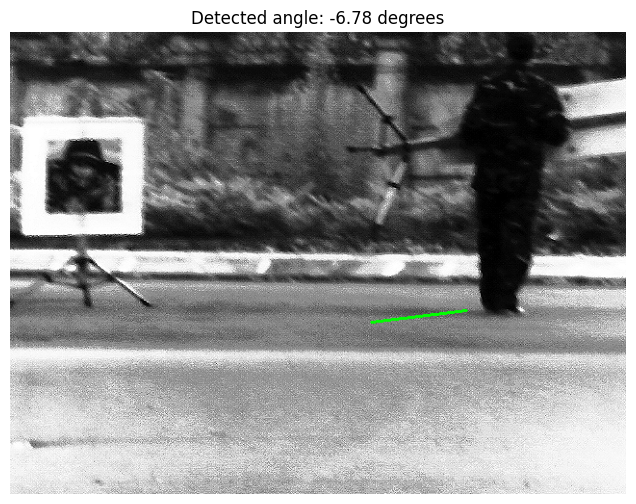

Detected skew angle: -6.78 degrees


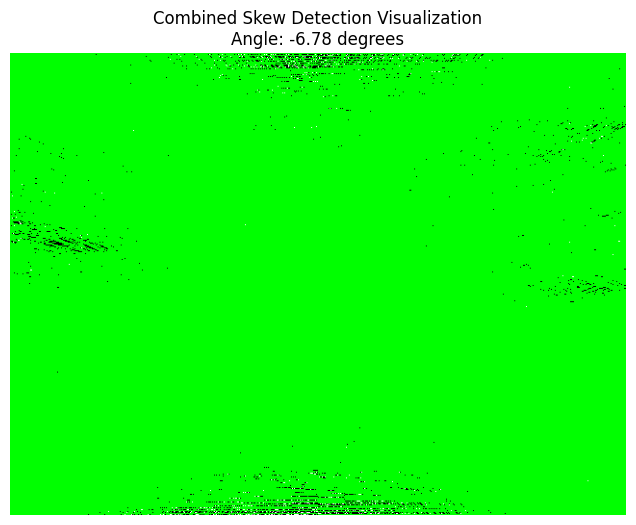


0: 512x640 4 bias, 857.9ms
Speed: 1.8ms preprocess, 857.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


In [4]:
if __name__ == "__main__":
    model_path = "yolo-models/yolo11x_bia-4.00.pt"
    image_path = "images/bo du lieu bia so 4/bia4 (12).bmp"

    model = load_model(model_path)
    img = load_image(image_path)
    preprocessed_img = preprocess_image(img, debug=True)
    results = run_inference(model, preprocessed_img)